***https://github.com/jeremiedbb/tutorial-euroscipy-2019.git***

**Requirements**
- python > 3.5
- jupyter


- numpy
- scipy


- cython
- numba


- snakeviz


- pandas
- matplotlib


- a C compiler supporting OpenMP
  (for macOS users: ``conda install gcc``)
  
**For conda users**, you can get a ready-to go environment by cloning the repo and running ``conda env create``.
  
<br></br>
<br></br>
<br></br>

In [1]:
import time
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numba
from numba import jit, njit, prange

%matplotlib inline
%load_ext cython
%load_ext snakeviz

<br></br>
<br></br>
# Speed up your python code
## An application with pairwise distances

<br></br>
### The problem

Let ``X`` and ``Y`` be two sets of points. For all points in `X`, find its closest point in `Y` w.r.t some given distance ``d``.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall x\in X, c(x) = \underset{y\in Y}{\operatorname{argmin}}{d(x,y)}$

We need to
- compute distances between all points in ``X`` and all points in ``Y``.
  Done using scipy ``cdist``.
- for each point in ``X`` find which point in ``Y`` minimize this distance.
  Done using numpy ``argmin``.

In [2]:
def cdist_argmin(X, Y, metric):
    distances = cdist(X, Y, metric=metric)
    argmins = np.argmin(distances, axis=1)
    
    return argmins

For example we can use it to draw the Voronoi diagram of the set of points ``Y``.

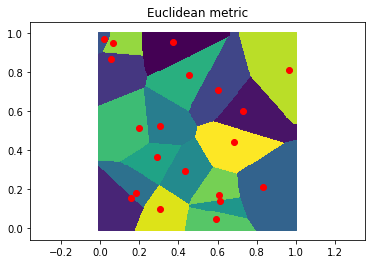

In [3]:
def plot(metric, title):
    Xv = np.array([[0.005*(i//200), 0.005*(i%200)] for i in range(40000)])
    Yv = np.random.RandomState(42).random_sample((20, 2))

    indices = cdist_argmin(Xv,Yv, metric=metric)
    plt.scatter(Xv[:,0], Xv[:,1], c=indices, s=10, marker='s')
    plt.scatter(Yv[:,0], Yv[:,1], color='red')
    plt.axis('equal')
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(title)

plot('euclidean', 'Euclidean metric')

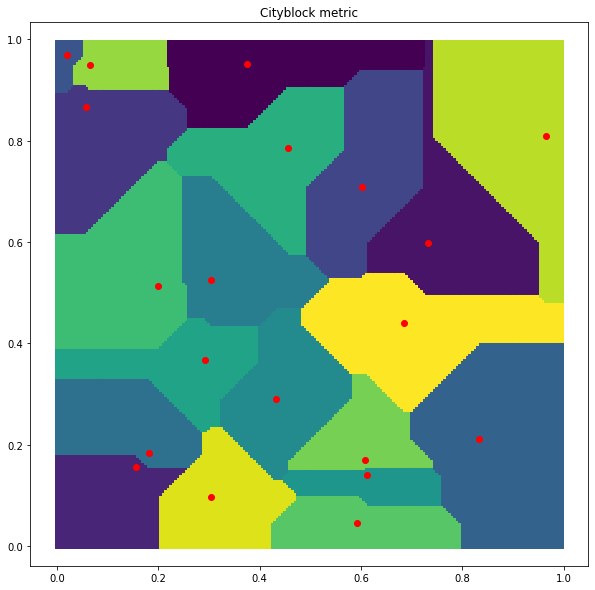

In [4]:
plot('cityblock', 'Cityblock metric')

<br></br>
### Efficiency considerations

Let's generate some data for our benchmarks.

In [5]:
X = np.random.random_sample((10000, 100))
Y = np.random.random_sample((100, 100))

In the ``cdist_argmin`` function, the critical part is the computation of the pairwise distances as shown in the following profiling. If we need to optimize something, this is the part of the code we want to look at.

In [6]:
%snakeviz cdist_argmin(X, Y, metric='cityblock')

 
*** Profile stats marshalled to file '/tmp/tmpz0im93kn'. 
Embedding SnakeViz in this document...


``cdist`` is very efficient when using a predefined metric but very slow when using a custom metric.

In [7]:
%timeit cdist(X, Y, metric='cityblock')

44.7 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
def cityblock(x, y):
    v = np.abs(x - y)
    
    return v.sum()

%timeit -r 3 -n 1 cdist(X, Y, metric=cityblock)

4.39 s ± 181 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The reason is that for a custom metric ``cdist`` relies on generic python code whereas for a predinefined metric it can rely on a specific C implementation.

It's a good candidate to move to compiled code.

<br></br>
### Our custom metric

Through the tutorial we'll use the following metric:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d(x,y) = \sum_{i=0}^{k}{(i + 1) |x_i - y_i|}$

In [9]:
def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)
    
    return v.dot(w)

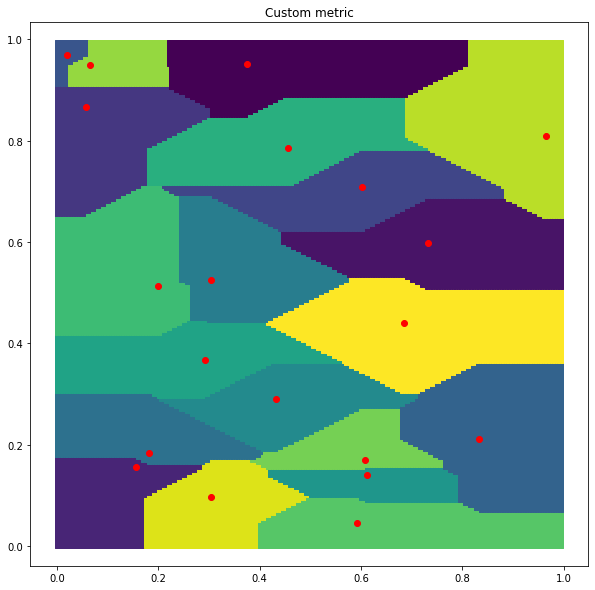

In [10]:
plot(custom_metric, 'Custom metric')

Helpers for accuracy testing and benchmarking

In [11]:
def test(func, X, Y):
    true_indices = cdist_argmin(X, Y)
    indices = func(X, Y)
    if np.all(true_indices == indices):
        print('correct result \o/')
    else:
        print('incorrect result TT')

In [12]:
benchs = pd.DataFrame(columns=['version', 'time (s)', 'speedup'])


def bench(func, X, Y, title):
    t = 0
    for i in range(20):
        t_ = time.time()
        func(X, Y)
        t_ = time.time() - t_
        t += t_
        if t_ > 0.5 and i >=3:
            break
    t /= (i + 1)

    i = benchs.shape[0]
    if i == 0:
        speedup = 1
    else:
        speedup = benchs.iloc[0]['time (s)'] / t
    benchs.loc[i] = [title, t, speedup]

    print(benchs)

<br></br>
### Baseline: 

In [13]:
def cdist_argmin(X, Y):
    distances = cdist(X, Y, metric=custom_metric)
    argmins = np.argmin(distances, axis=1)
    
    return argmins

In [14]:
test(cdist_argmin, X, Y)

correct result \o/


In [15]:
bench(cdist_argmin, X, Y, 'baseline')

    version  time (s) speedup
0  baseline  4.057307       1


<br></br>
### Cython

#### - Python is valid Cython

In [16]:
%%cython -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)
    
    return np.dot(v, w)

def cython_cdist_argmin(X, Y):
    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            distances[i, j] = custom_metric(x, y)
    
    return np.argmin(distances, axis=1)

In [17]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [18]:
bench(cython_cdist_argmin, X, Y, "cython pure python")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026


<br></br>
**Cython annotations** (-a option) show which line contains interaction with python objects.

In [19]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            distances[i, j] = custom_metric(x, y)
    
    return np.argmin(distances, axis=1)

<br></br>
#### - Get rid of python interactions within the nested loop

Move from python variables to typed variables  
``cdef <type> var = ...``

Python ``range`` keyword is compiled into efficient C code  
e.g. ``for i in range(10)``  

In [20]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(distances, axis=1)

``distances`` is still a python object (numpy array). We can get an efficient access to its data using a **typed memoryview**.  

In [21]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(distances, axis=1)

``custom_metric`` is a python function with python arguments implemented in pure python.  
- functions maint to be used in python should be defined using `def`  
- functions maint to be used within cython should be defined using `cdef`, and typed.

We also need to use memoryviews for X and Y.

In [22]:
%%cython -a -f

import numpy as np


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [23]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [24]:
bench(cython_cdist_argmin, X, Y, "cdef custom_metric")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891


<br></br>
Cython checks that indexing memoryviews stays within bounds and allows negative indexing. We can disable both using ``boundscheck`` and ``wraparound`` **cython directives**.

In [25]:
%%cython -a -f
#cython: boundscheck=False, wraparound=False

import numpy as np


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [26]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [27]:
bench(cython_cdist_argmin, X, Y, "cython directives")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891
3   cython directives  0.171358  23.6774


<br></br>
#### - Getting the most out of Cython

If we know X and Y will always have the same **memory layout** we can give that information to cython which will produce specialized code.  
Let's assume X and Y are C ordered.

In [28]:
%%cython -a -f
#cython: boundscheck=False, wraparound=False

import numpy as np


cdef double custom_metric(double[::1] x, double[::1] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [29]:
bench(cython_cdist_argmin, X, Y, "C ordered")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891
3   cython directives  0.171358  23.6774
4           C ordered  0.165416   24.528


Use functions already implemented in the C standard library: ``fabs``.  
C functions need to be imported with the ``cimport`` keyword.

In [30]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double[::1] x, double[::1] y):
    cdef:
        int n = x.shape[0]
        double res = 0.0
        int i

    for i in range(n):
        res += (i + 1) * fabs(x[i] - y[i])
        
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [31]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [32]:
bench(cython_cdist_argmin, X, Y, "fabs")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891
3   cython directives  0.171358  23.6774
4           C ordered  0.165416   24.528
5                fabs  0.139764  29.0296


GCC can't **vectorize** reduction.
We can either:
- tell GCC that it's fine to reorder operations
- manually unroll the loop

We can specify compiler flags through the ``-c`` option.

In [33]:
%%cython -c=-Ofast -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double res = 0.0
        int i

    for i in range(n):
        res += (i + 1) * fabs(x[i] - y[i])
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [34]:
bench(cython_cdist_argmin, X, Y, "-Ofast")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891
3   cython directives  0.171358  23.6774
4           C ordered  0.165416   24.528
5                fabs  0.139764  29.0296
6              -Ofast  0.092040  44.0818


Manually unroll the loop will be worth only if we use pointers.

In [35]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        double res = 0.0
        int i

    for i in range(k):
        res += (i + 1) * fabs(x[i] - y[i])

    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [36]:
bench(cython_cdist_argmin, X, Y, "pointers")

              version  time (s)  speedup
0            baseline  4.057307        1
1  cython pure python  3.621748  1.12026
2  cdef custom_metric  0.667440  6.07891
3   cython directives  0.171358  23.6774
4           C ordered  0.165416   24.528
5                fabs  0.139764  29.0296
6              -Ofast  0.092040  44.0818
7            pointers  0.116593  34.7988


In [37]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        int rem = k % 4
        double res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [38]:
bench(cython_cdist_argmin, X, Y, "pointers + unrolled loop")

                    version  time (s)  speedup
0                  baseline  4.057307        1
1        cython pure python  3.621748  1.12026
2        cdef custom_metric  0.667440  6.07891
3         cython directives  0.171358  23.6774
4                 C ordered  0.165416   24.528
5                      fabs  0.139764  29.0296
6                    -Ofast  0.092040  44.0818
7                  pointers  0.116593  34.7988
8  pointers + unrolled loop  0.086230   47.052


<br></br>
### More cython

#### Profiling cython code

Enabling the ``profile`` cython directive will allow us to profile our code with ``snakeviz``.

In [39]:
%%cython -f
#cython: boundscheck=False, wraparound=False, profile=True

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        int rem = k % 4
        double res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [40]:
%snakeviz cython_cdist_argmin(X, Y)

 
*** Profile stats marshalled to file '/tmp/tmp7b2gz6aj'. 
Embedding SnakeViz in this document...


<br></br>
#### Generic code with fused types

Our current code is specific to ``double`` dtype (np.float64).

In [41]:
cython_cdist_argmin(X.astype(np.float32), Y.astype(np.float32))

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [43]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs

ctypedef fused floating:
    float
    double

cdef floating custom_metric(floating* x, floating* y, int k):
    cdef:
        int rem = k % 4
        floating res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(floating[:, ::1] X, floating[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

    dtype = np.float32 if floating is float else np.float64
    cdef floating[:, ::1] distances = np.empty((nx, ny), dtype=dtype)
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [44]:
cython_cdist_argmin(X.astype(np.float32), Y.astype(np.float32))

array([54, 35, 85, ..., 76, 84, 37])

<br></br>
#### Parallelism with OpenMP

Simply replace the ``range`` keyword by the ``prange`` keyword.

In [45]:
%%cython -c=-fopenmp -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs
from cython.parallel cimport prange

ctypedef fused floating:
    float
    double

cdef floating custom_metric(floating* x, floating* y, int k) nogil:
    cdef:
        int rem = k % 4
        floating res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(floating[:, ::1] X, floating[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

    dtype = np.float32 if floating is float else np.float64
    cdef floating[:, ::1] distances = np.empty((nx, ny), dtype=dtype)
    
    for i in prange(nx, num_threads=2, nogil=True):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [46]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [47]:
bench(cython_cdist_argmin, X, Y, "prange")

                    version  time (s)  speedup
0                  baseline  4.057307        1
1        cython pure python  3.621748  1.12026
2        cdef custom_metric  0.667440  6.07891
3         cython directives  0.171358  23.6774
4                 C ordered  0.165416   24.528
5                      fabs  0.139764  29.0296
6                    -Ofast  0.092040  44.0818
7                  pointers  0.116593  34.7988
8  pointers + unrolled loop  0.086230   47.052
9                    prange  0.046445   87.358


<br></br>
<br></br>
<br></br>
<br></br>
### Numba

Like Cython, Numba can work with Python objects but is much more efficient if it can compile a function without involving the Python interpreter. It's called the **nopython** mode.

To tell Numba which function needs to be compiled, you just have to decorate it: ``@jit``.   
``@jit(nopython=True)`` or ``@njit`` enforces the nopython mode.

In [48]:
@njit
def f(x, y):
    return x.dot(y)

``f`` is compiled when called for the first time so the first call is longer

In [49]:
%time f(X[0], Y[0])
%time f(X[0], Y[0])

CPU times: user 380 ms, sys: 4 ms, total: 384 ms
Wall time: 224 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


26.353596146904117

<br></br>
#### - Type inference

Numba infers the types of the function and its argument at first compilation.

In [50]:
f.inspect_types()

f (array(float64, 1d, C), array(float64, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-48-a61d0f22781f>
# --- LINE 1 --- 
# label 0

@njit

# --- LINE 2 --- 

def f(x, y):

    # --- LINE 3 --- 
    #   x = arg(0, name=x)  :: array(float64, 1d, C)
    #   y = arg(1, name=y)  :: array(float64, 1d, C)
    #   $0.2 = getattr(value=x, attr=dot)  :: BoundFunction((<class 'numba.types.npytypes.Array'>, 'dot') for array(float64, 1d, C))
    #   del x
    #   $0.4 = call $0.2(y, func=$0.2, args=[Var(y, <ipython-input-48-a61d0f22781f> (3))], kws=(), vararg=None)  :: (array(float64, 1d, C),) -> float64
    #   del y
    #   del $0.2
    #   $0.5 = cast(value=$0.4)  :: float64
    #   del $0.4
    #   return $0.5

    return x.dot(y)




<br></br>
#### - Numba and Numpy

Numba understands Numpy arrays and supports a lot of Numpy features, meaning using Numpy functions in nopython mode will be compiled into efficient code.

In [51]:
@njit
def numba_custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)
    
    return v.dot(w)


@njit
def numba_cdist_argmin(X, Y):
    nx = X.shape[0]
    ny = Y.shape[0]

    distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = numba_custom_metric(X[i], Y[j])
    
    return np.argmin(distances, axis=1)

However this code doesn't compile because:
- Numba support for ``np.dot`` needs to be called with arrays of same dtype
- Numba support for ``np.argmin`` does not handle the ``axis`` parameter.

In [52]:
@njit
def numba_custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1).astype(x.dtype)
    
    return v.dot(w)


@njit
def numba_cdist(X, Y):
    nx = X.shape[0]
    ny = Y.shape[0]

    distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = numba_custom_metric(X[i], Y[j])
    
    return distances

            
def numba_cdist_argmin(X, Y):
    distances = numba_cdist(X, Y)

    return np.argmin(distances, axis=1)

In [53]:
test(numba_cdist_argmin, X, Y)

correct result \o/


In [54]:
bench(numba_cdist_argmin, X, Y, "naive numba")

                     version  time (s)  speedup
0                   baseline  4.057307        1
1         cython pure python  3.621748  1.12026
2         cdef custom_metric  0.667440  6.07891
3          cython directives  0.171358  23.6774
4                  C ordered  0.165416   24.528
5                       fabs  0.139764  29.0296
6                     -Ofast  0.092040  44.0818
7                   pointers  0.116593  34.7988
8   pointers + unrolled loop  0.086230   47.052
9                     prange  0.046445   87.358
10               naive numba  0.520833  7.79003


<br></br>
#### - Fastmath optimization

Like with cython, telling the compiler that it can reorder operation as it wants can speed things up significantly. This is done through the **fastmath** option.

However we need to rewrite our function in a more C-like way to benefit from it.

In [55]:
@njit(fastmath=True)
def numba_custom_metric(x, y):
    res = 0

    for i in range(x.shape[0]):
        v = x[i] - y[i]
        if v < 0:
            v = - v
        res += (i + 1) * v
    
    return res


@njit(fastmath=True)
def numba_cdist(X, Y):
    nx = X.shape[0]
    ny = Y.shape[0]

    distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = numba_custom_metric(X[i], Y[j])
    
    return distances

In [56]:
test(numba_cdist_argmin, X, Y)

correct result \o/


In [57]:
bench(numba_cdist_argmin, X, Y, "numba fastmath")

                     version  time (s)  speedup
0                   baseline  4.057307        1
1         cython pure python  3.621748  1.12026
2         cdef custom_metric  0.667440  6.07891
3          cython directives  0.171358  23.6774
4                  C ordered  0.165416   24.528
5                       fabs  0.139764  29.0296
6                     -Ofast  0.092040  44.0818
7                   pointers  0.116593  34.7988
8   pointers + unrolled loop  0.086230   47.052
9                     prange  0.046445   87.358
10               naive numba  0.520833  7.79003
11            numba fastmath  0.102180  39.7074


<br></br>
### More Numba

#### - Profiling

You can profile Numba compiled functions without additional code.

In [58]:
%snakeviz numba_cdist_argmin(X, Y)

 
*** Profile stats marshalled to file '/tmp/tmpg34ey7p9'. 
Embedding SnakeViz in this document...


<br></br>
#### - Parallel loop in Numba

Simply replace ``range`` by ``prange`` and enable the ``parallel`` option.
Currently, the only way to specify the number of threads to be use for the ``prange`` is through the ``NUMBA_NUM_THREADS`` environment variable (before imports).

In [59]:
@njit(parallel=True)
def numba_cdist(X, Y):
    nx = X.shape[0]
    ny = Y.shape[0]

    distances = np.empty((nx, ny))
    
    for i in prange(nx):
        for j in range(ny):
            distances[i, j] = numba_custom_metric(X[i], Y[j])
    
    return distances

In [60]:
test(numba_cdist_argmin, X, Y)

correct result \o/


In [61]:
bench(numba_cdist_argmin, X, Y, "numba prange")

                     version  time (s)  speedup
0                   baseline  4.057307        1
1         cython pure python  3.621748  1.12026
2         cdef custom_metric  0.667440  6.07891
3          cython directives  0.171358  23.6774
4                  C ordered  0.165416   24.528
5                       fabs  0.139764  29.0296
6                     -Ofast  0.092040  44.0818
7                   pointers  0.116593  34.7988
8   pointers + unrolled loop  0.086230   47.052
9                     prange  0.046445   87.358
10               naive numba  0.520833  7.79003
11            numba fastmath  0.102180  39.7074
12              numba prange  0.043949  92.3195


Numba supports the OpenMP and TBB **threading layers** (and a simple built-in threading layer in case none of those is found).

``pip install tbb`` will install TBB.

In [62]:
numba.threading_layer()

'omp'